In [20]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import story_helper
from sasc.modules.fmri_module import convert_module_num_to_voxel_num

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# load data and corresponding resps
pilot_data_dir = '/home/chansingh/mntv1/deep-fMRI/story_data/20230504'
resp_np_files = os.listdir(pilot_data_dir)
resps_dict = {
    k: np.load(join(pilot_data_dir, k))
    for k in tqdm(resp_np_files)
}

story_mapping = {
    "uts02_pilot_gpt4_mar28___ver=v4_noun___seed=3": 'GenStory2_resps.npy',
    "uts02_pilot_gpt4_mar28___ver=v5_noun___seed=4": 'GenStory6_resps.npy',
    "uts02_pilot_gpt4_mar28___ver=v5_noun___seed=1": 'GenStory4_resps.npy',
    "uts02_pilot_gpt4_mar28___ver=v5_noun___seed=2": 'GenStory5_resps.npy',
    "uts02_pilot_gpt4_mar28___ver=v4_noun___seed=4": 'GenStory3_resps.npy',
    "uts02_pilot_gpt4_mar28___ver=v4_noun___seed=1": 'GenStory1_resps.npy',
}

STORIES_DIR = join(sasc.config.RESULTS_DIR, 'pilot_v1')
story_names = story_mapping.keys() # os.listdir(STORIES_DIR)

story_data = defaultdict(list)
for story_name in story_names:
    story_data['timing'].append(pd.read_csv(join(STORIES_DIR, story_name, 'timings_processed.csv')))
    story_data['story_name_original'].append(story_name)
    story_data['story_name_new'].append(story_mapping[story_name])
    story_data['story_text'].append(open(join(STORIES_DIR, story_name, 'story.txt'), 'r').read())    
    story_data['rows'].append(pd.read_csv(join(STORIES_DIR, story_name, 'rows.csv')))

    # print(story_name, story_data['timing'][-1]['time_running'].round(1).max())

100%|██████████| 6/6 [02:23<00:00, 23.89s/it]


# Look at heatmaps

/tmp/ipykernel_609827/4294342029.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rw["voxel_num"] = rw.apply(


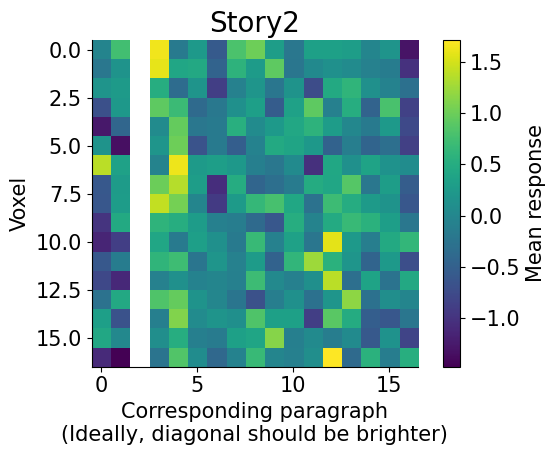

In [21]:
mats = []

for story_num in [0, 1, 2, 3, 4, 5]:
    rows = story_data["rows"][story_num]
    rw = rows[
        [
            "expl",
            "module_num",
            "top_explanation_init_strs",
            "subject",
            "fmri_test_corr",
            "top_score_synthetic",
            "roi_anat",
            "roi_func",
        ]
    ]
    rw["voxel_num"] = rw.apply(
        lambda row: convert_module_num_to_voxel_num(row["module_num"], row["subject"]),
        axis=1,
    )
    paragraphs = story_data["story_text"][story_num].split("\n\n")
    assert len(paragraphs) == len(rw), (len(paragraphs), len(rw))

    timing = story_data["timing"][story_num]

    resp_story = resps_dict[story_data["story_name_new"][story_num]].T  # (voxels, time)
    resp_chunks = story_helper.get_resp_chunks(timing, paragraphs, resp_story)
    voxel_nums = rw["voxel_num"].values
    # resp = resp_paragraphs[]

    mat = np.zeros((len(rw), len(paragraphs)))
    for i in range(len(paragraphs)):
        # resp_paragraph = resp[:, start_times[i] : end_times[i]]
        # while resp_paragraph.shape[1] <= 2 * OFFSET:
            # OFFSET -= 1
        mat[:, i] = resp_chunks[i][voxel_nums].mean(axis=1)

        # find the middle 3 values of resp_paragraph
        # # # mid = resp_paragraph.shape[1] // 2
        # # resp_middle = resp_paragraph[:, mid - 1 : mid + 2]
        # mat[:, i] = resp_middle.mean(axis=1)

    # visualize (ignore the first column)
    mat[:, 0] = np.nan
    # mat = softmax(mat, axis=0)

    args = np.argsort(rw["voxel_num"].values)
    mat = mat[args, :][:, args]
    mats.append(deepcopy(mat))

    plt.imshow(mat)
    plt.colorbar(label="Mean response")
    plt.xlabel("Corresponding paragraph\n(Ideally, diagonal should be brighter)")
    plt.ylabel("Voxel")
    plt.title(f"{story_data['story_name_new'][story_num][3:-10]}")
    plt.show()
expls = rw.sort_values(by="voxel_num")["expl"].values

## Make average plot

In [18]:
mats = np.array(mats) # (6, 17, 17)
m = np.nanmean(mats, axis=0)
n = m.shape[0]
diag_means = np.diag(m)
diag_mean = np.nanmean(diag_means)

# get mean of each row excluding the diagonal
off_diag_means = m.mean(axis=1) - (diag_means / n)
off_diag_mean = off_diag_means.mean()

<>:12: DeprecationWarning: invalid escape sequence '\s'
<>:12: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_609827/2582196609.py:12: DeprecationWarning: invalid escape sequence '\s'
  plt.ylabel('Mean voxel response ($\sigma_f$)')


mean 0.3066835402533401


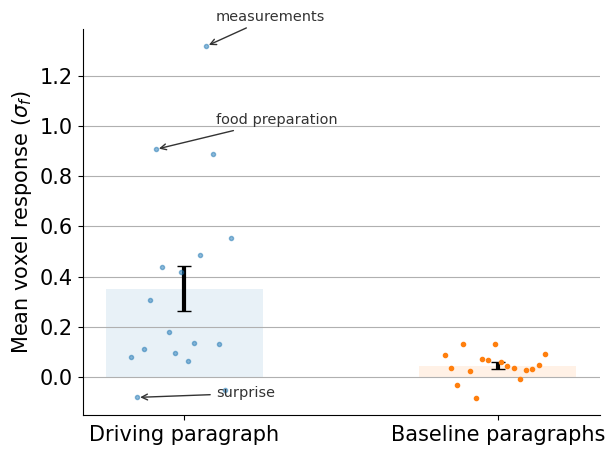

In [19]:
x = np.arange(n) - n / 2

plt.bar(1, diag_mean, width=0.5, label='Diagonal', alpha=0.1, color='C0')
plt.errorbar(1, diag_mean, yerr=diag_means.std() / np.sqrt(len(diag_means)), fmt='.', label='Diagonal', ms=0, color='black', elinewidth=3, capsize=5, lw=1)
plt.plot(1 + x/50, diag_means, '.', color='C0', alpha=0.5)

plt.bar(2, off_diag_mean, width=0.5, label='Off-diagonal', alpha=0.1, color='C1')
plt.errorbar(2, off_diag_mean, yerr=off_diag_means.std() / np.sqrt(len(off_diag_means)), fmt='.', label='Diagonal', ms=0, color='black', elinewidth=3, capsize=5)
plt.plot(2 + x/50, off_diag_means, '.', color='C1')

plt.xticks([1, 2], ['Driving paragraph', 'Baseline paragraphs'])
plt.ylabel('Mean voxel response ($\sigma_f$)')
plt.grid(axis='y')

# annotate the point with the highest mean
kwargs = dict(
    arrowprops=dict(arrowstyle='->', color='#333'), fontsize='x-small', color='#333'
)
idx = np.argmax(diag_means)
plt.annotate(f"{expls[idx]}", (1 + x[idx]/50, diag_means[idx]), xytext=(1.1, diag_means[idx] + 0.1), **kwargs)

# annotate the point with the second highest mean
idx = np.argsort(diag_means)[-2]
plt.annotate(f"{expls[idx]}", (1 + x[idx]/50, diag_means[idx]), xytext=(1.1, diag_means[idx] + 0.1), **kwargs)

# annotate the point with the lowest mean
idx = np.argmin(diag_means)
plt.annotate(f"{expls[idx]}", (1 + x[idx]/50, diag_means[idx]), xytext=(1.1, diag_means[idx]), **kwargs)
plt.tight_layout()
print('mean', diag_mean - off_diag_mean)
plt.savefig('../results/pilot_means.pdf')

### Story-level differences

In [ ]:
d = defaultdict(list)
for i in range(len(mats)):
    m = mats[i]
    d['driving'].append(np.nanmean(np.diag(m)))
    d['baseline'].append(np.nanmean(m[~np.eye(m.shape[0], dtype=bool)]))
    d['story'].append(story_data['story_name_new'][i][3:-10])

df = pd.DataFrame.from_dict(d)

# make barplot comparing driving and baseline
df = df.melt(id_vars='story', value_vars=['driving', 'baseline'], var_name='condition', value_name='mean')
df = df.sort_values(by='story')
sns.barplot(data=df, x='story', y='mean', hue='condition')
plt.ylabel('Mean voxel response ($\sigma_f$)')
plt.show()

### Voxel-level differences

In [ ]:
rw = rw.sort_values(by="voxel_num")
rw['mean_resp_diff'] = diag_means # - off_diag_means

# ax = sns.pairplot(rw, vars=['mean_resp_diff', 'top_score_synthetic', 'fmri_test_corr'], hue='expl')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1))

plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.plot(rw['top_score_synthetic'], rw['mean_resp_diff'], 'o')
plt.ylabel('Mean voxel response')
plt.xlabel('Synthetic score')

plt.subplot(1, 2, 2)
plt.plot(rw['fmri_test_corr'], rw['mean_resp_diff'], 'o')
plt.xlabel('Predicted test correlation')

plt.tight_layout()
plt.show()

### Voxel-level differences

In [ ]:
for i in range(resp.shape[0]):
    plt.plot(resp[i])

In [ ]:
rw.drop(columns='module_num').to_csv('../results/pilot_voxels_metadata.csv', index=False)